# Spatial dFBA Process

This notebook demonstrates a Spatial Dynamic Flux Balance Analysis (DFBA) model, simulating and visualizing biomass concentrations over time in a two-dimensional (2D) field. The model integrates diffusion, advection, and sinking mechanisms to show how these processes influence biomass distributions at each timestep across the grid bins.

**Key components of the notebook:**
- **Initialization**: Setting up the spatial environment with defined bounds, bins, and initial states for molecules and species.
- **Process Simulation**: Using the `SpatialDFBA` class to simulate species growth based on local conditions and kinetic parameters.
- **Diffusion and Advection**: Applying diffusion and advection processes to update molecule concentrations and biomass distributions.
- **Visualization**: Plotting the objective flux and spatial fields to visualize biomass and molecule concentrations over time.

Run the notebook to observe how different species interact and grow in a spatially heterogeneous environment, influenced by diffusion, advection, and sinking mechanisms.


## Imports

In [1]:
# Standard Library Imports
import base64
import io
import os
import shutil

# Third-Party Library Imports
import imageio.v2 as imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from cobra.io import read_sbml_model

# Vivarium Imports
from vivarium.core.engine import Engine
from vivarium.plots.topology import plot_topology

# Project-Specific Imports
from processes.spatial_dfba import SpatialDFBA
from plots.field import plot_objective_flux, plot_fields_temporal


## Vivarium diagram of the Spatial DFBA process (**WORK IN PROGRESS**)

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Loaded model for Alteromonas
Writing out/spatial_dfba_topology


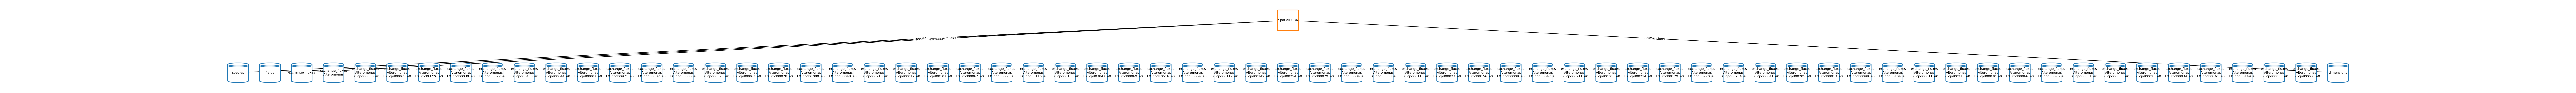

In [18]:
spatial_dfba = SpatialDFBA({'flux_id_map': {}})
ports = spatial_dfba.ports_schema()
exchange_ports = ports['exchange_fluxes']['Alteromonas'].keys()
fig = plot_topology(spatial_dfba,
                    settings={'remove_nodes':
                                  [['exchange_fluxes', 'Alteromonas', flux] for flux in exchange_ports]},
                    out_dir='out',
                    filename='spatial_dfba_topology')

## simulation
In the following simulation, the user can set the **species** (for example, E. coli and Alteromonas) and available **molecules** (for example, glucose and oxygen) in each grid bin, as well as **total time** for the simulation. Initially, we uniformly or randomly distribute molecules and species in the field. Then, we compute the dFBA at each timestep at each bin for the species in that bin. 

In [3]:
# Configuration
total_time = 100
config = {
    'bounds': [6, 6],  # dimensions of the environment
    'nbins': [3, 3],   # division into bins
    'molecules': ['glucose', 'oxygen'],  # available molecules
    'species_info': [
        {
            'name': 'Alteromonas',
            'model': '../data/Alteromonas_Model.xml',  # Path to FBA model file
            'flux_id_map': {
                'glucose': 'EX_cpd00027_e0',
                'oxygen': 'EX_cpd00007_e0'
            },
            'kinetic_params': {
                'glucose': (0.5, 0.0005),  # Km, Vmax for glucose
                'oxygen': (0.3, 0.0005),   # Km, Vmax for oxygen
            },
            # "fixed_bounds": {
            #     'EX_cpd00149_e0': (-10, 10)  # Setting fixed bounds for Alteromonas
            # }
        },
        {
            'name': 'ecoli',
            'model': '../data/iECW_1372.xml',  # Path to E. coli model file
            'flux_id_map': {
                'glucose': 'EX_glc__D_e',
                'oxygen': 'EX_o2_e'
            },
            'kinetic_params': {
                'glucose': (0.4, 5),  # Km, Vmax for glucose
                'oxygen': (0.25, 0.6),  # Km, Vmax for oxygen
            },
            #     "fixed_bounds": {
            #         'EX_fe3dhbzs_e': (0, 10)  # Setting fixed bounds for E. coli
            # }
        }
    ]
}

# Initialize the process
spatial_dfba = SpatialDFBA(config)

# Initial state configuration
## random initial fields
initial_field_config = {
    'random': {
        'glucose': 10,
        'oxygen': 200.0,
    }}
initial_field = spatial_dfba.initial_state(initial_field_config)

# uniform initial species
initial_species_config = {
    'uniform': {
        'species': {
            'ecoli': 0.5,
            'Alteromonas': 0.3
        }}}
initial_species = spatial_dfba.initial_state(initial_species_config)

# merge into initial state
initial_state = initial_field.copy()
initial_state['species'] = initial_species['species']

# Create the Vivarium simulation engine
sim = Engine(
    initial_state=initial_state,
    processes={'spatial_dfba': spatial_dfba},
    topology={'spatial_dfba': {
        'fields': ('fields',),
        'species': ('species',),
        'exchange_fluxes': ('exchange_fluxes',),
        'dimensions': ('dimensions',),
    }})

# Run the simulation
sim.update(total_time)

# Get the results
data = sim.emitter.get_timeseries()

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Loaded model for Alteromonas
Loaded model for ecoli
No specific initialization for species 'Alteromonas', defaulting to zero.
No specific initialization for species 'ecoli', defaulting to zero.
No specific initialization for molecule 'glucose', defaulting to zero.
No specific initialization for molecule 'oxygen', defaulting to zero.

Simulation ID: 4f78b614-2cfa-11ef-a31b-064a537592bc
Created: 06/17/2024 at 18:38:25
Completed in 19.67 seconds


## plot
In the following plot, the top row indicates the growth of E. coli and Alteromonas over time. At a certain point, E. coli stops growing due to the depletion of glucose in the environment. However, Alteromonas continues to grow because it can utilize other nutrient sources, while only glucose limits were set. The bottom row shows the amounts of glucose and oxygen in the environment. This plot illustrates the dynamics within one of the bins in the grid.



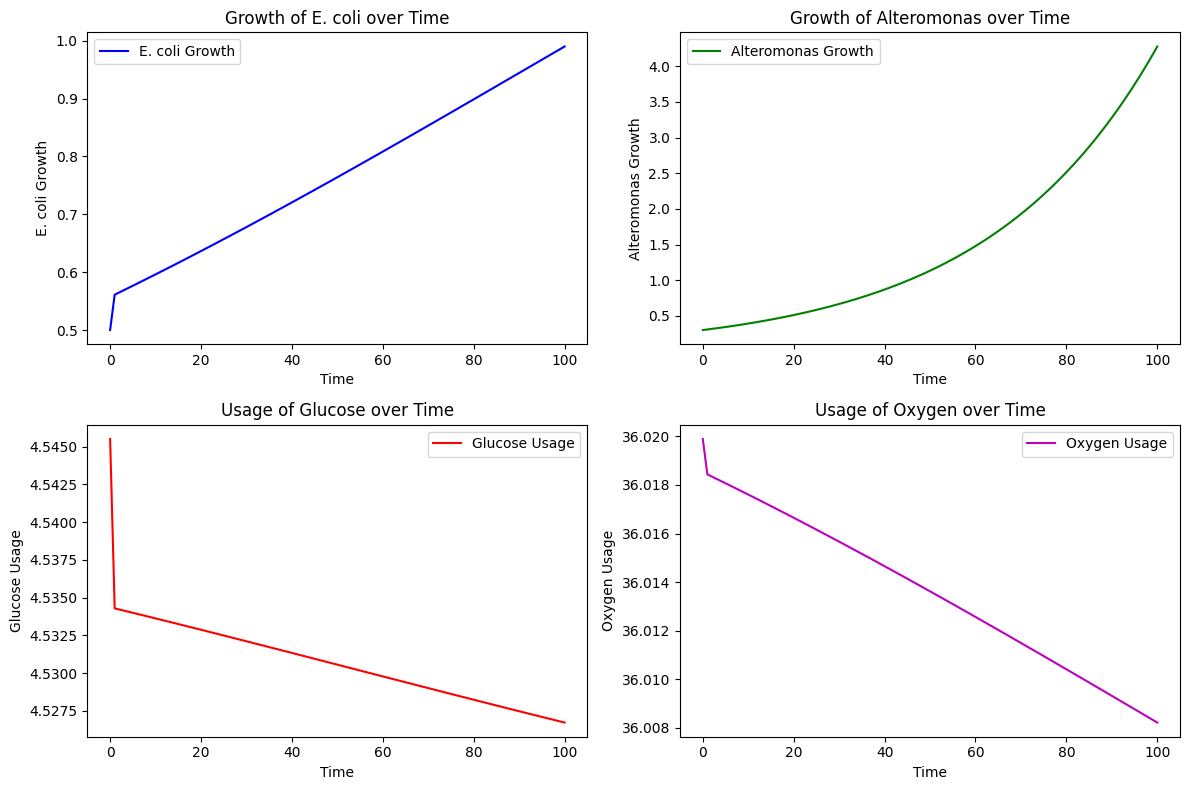

In [4]:
# Extracting the data for plotting
time_points = data["time"]
ecoli_growth = [data["species"]["ecoli"][t][0][0] for t in range(len(time_points))]
alteromonas_growth = [data["species"]["Alteromonas"][t][0][0] for t in range(len(time_points))]
glucose_usage = [data["fields"]["glucose"][t][0][0] for t in range(len(time_points))]
oxygen_usage = [data["fields"]["oxygen"][t][0][0] for t in range(len(time_points))]

# Plotting
plt.figure(figsize=(12, 8))

# Growth of E. coli over time
plt.subplot(2, 2, 1)
plt.plot(time_points, ecoli_growth, label='E. coli Growth', color='b')
plt.xlabel('Time')
plt.ylabel('E. coli Growth')
plt.title('Growth of E. coli over Time')
plt.legend()

# Growth of Alteromonas over time
plt.subplot(2, 2, 2)
plt.plot(time_points, alteromonas_growth, label='Alteromonas Growth', color='g')
plt.xlabel('Time')
plt.ylabel('Alteromonas Growth')
plt.title('Growth of Alteromonas over Time')
plt.legend()

# Usage of glucose over time
plt.subplot(2, 2, 3)
plt.plot(time_points, glucose_usage, label='Glucose Usage', color='r')
plt.xlabel('Time')
plt.ylabel('Glucose Usage')
plt.title('Usage of Glucose over Time')
plt.legend()

# Usage of oxygen over time
plt.subplot(2, 2, 4)
plt.plot(time_points, oxygen_usage, label='Oxygen Usage', color='m')
plt.xlabel('Time')
plt.ylabel('Oxygen Usage')
plt.title('Usage of Oxygen over Time')
plt.legend()

plt.tight_layout()
plt.show()

## exchange flux table
The table below displays the exchange flux of Alteromonas at various time steps during the simulation.

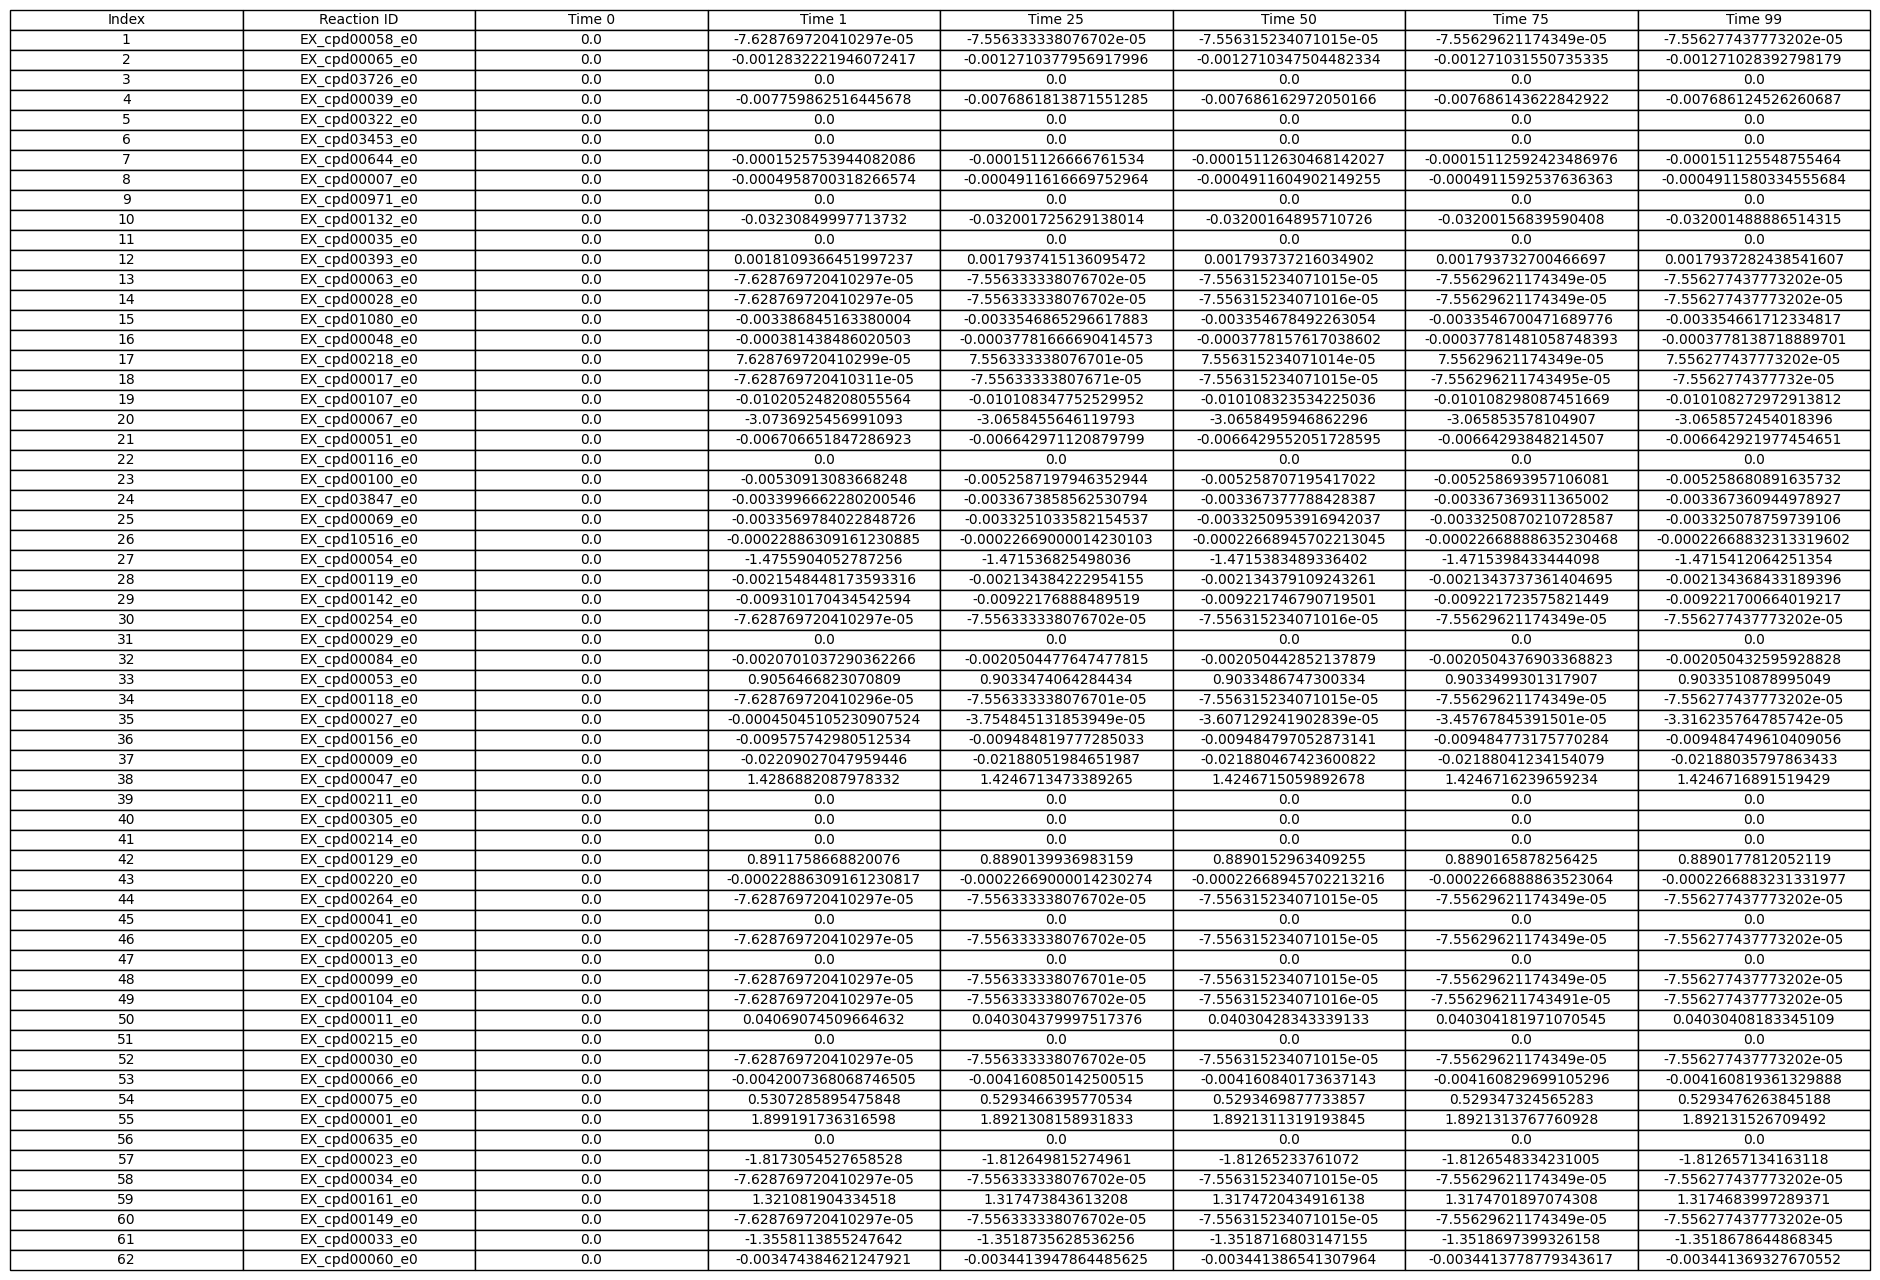

In [5]:
# Exchange fluxes of Alteromonas at specific timesteps.
time_steps = [0, 1, total_time // 4, total_time // 2, total_time * 3 // 4, total_time - 1]
reaction_ids = list(data["exchange_fluxes"]['Alteromonas'].keys())

# Create a dictionary to hold the flux values for each reaction ID
flux_data = {'Index': range(1, len(reaction_ids) + 1), 'Reaction ID': reaction_ids}

for i, t in enumerate(time_steps):
  flux_data[f'Time {t}'] = [data["exchange_fluxes"]['Alteromonas'][reaction_id]["flux"][t][0][0] for reaction_id in reaction_ids]

# Create a DataFrame
df = pd.DataFrame(flux_data)

# Display the DataFrame as a table
fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()

## reaction_id info
In the following code snippet, user can provide the reaction ID and see the Reaction Name, Reaction Equation, Lower Bound, and Upper Bound.

In [6]:
# Define the reaction ID you want to retrieve information for
reaction_id = 'EX_cpd00161_e0'

# Retrieve the details for the specified reaction ID
reaction_details = data["exchange_fluxes"]['Alteromonas'][reaction_id]

# Extract and print the reaction details
reaction_name = reaction_details['name'][0]
reaction_equation = reaction_details['reaction'][0]
lower_bound = reaction_details['lower_bound'][0]
upper_bound = reaction_details['upper_bound'][0]

print(f"Reaction ID: {reaction_id}")
print(f"Reaction Name: {reaction_name}")
print(f"Reaction Equation: {reaction_equation}")
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

Reaction ID: EX_cpd00161_e0
Reaction Name: Exchange for L-Threonine_e0
Reaction Equation: cpd00161_e0 <=> 
Lower Bound: -1000.0
Upper Bound: 1000.0


## plot
The first row of the following plots shows the biomass for each species at each time step in each grid bin. It also shows the overall biomass (biomass of all present species). The bottom row shows the concentration of molecules in the environment at each grid bin at each time step.

In [7]:
def precompute_global_min_max(data, names, data_key):
    num_elements = len(names)
    global_min = [np.inf] * num_elements
    global_max = [-np.inf] * num_elements

    for time in data["time"]:
        time_index = int(data["time"].index(time))  # Ensure time_index is an integer
        for j, element_id in enumerate(names):
            current_data = data[data_key][element_id][time_index]
            global_min[j] = min(global_min[j], np.min(current_data))
            global_max[j] = max(global_max[j], np.max(current_data))
    
    return global_min, global_max

def plot_elements_to_gif(data, total_time, element_names, data_key, temp_dir, file_prefix, include_total_biomass=False):
    valid_time_points = list(range(total_time + 1))
    num_elements = len(element_names)
    images = []

    global_min, global_max = precompute_global_min_max(data, element_names, data_key)
    
    if include_total_biomass:
        global_min.append(np.inf)
        global_max.append(-np.inf)
        for time in valid_time_points:
            time_index = int(data["time"].index(time))  # Ensure time_index is an integer
            total_biomass = np.zeros_like(data[data_key][element_names[0]][time_index])
            for element_id in element_names:
                total_biomass += data[data_key][element_id][time_index]
            global_min[-1] = min(global_min[-1], np.min(total_biomass))
            global_max[-1] = max(global_max[-1], np.max(total_biomass))

    for time in valid_time_points:
        time_index = int(data["time"].index(time))  # Ensure time_index is an integer
        if include_total_biomass:
            total_biomass = np.zeros_like(data[data_key][element_names[0]][time_index])
        
        fig, axs = plt.subplots(1, num_elements + (1 if include_total_biomass else 0), figsize=(num_elements * 5, 5), squeeze=False)
        
        for j, element_id in enumerate(element_names):
            current_data = data[data_key][element_id][time_index]
            if include_total_biomass:
                total_biomass += current_data
            im = axs[0, j].imshow(current_data, cmap='viridis', vmin=global_min[j], vmax=global_max[j])
            axs[0, j].set_title(element_id)
            axs[0, j].set_xticks([])
            axs[0, j].set_yticks([])
            plt.colorbar(im, ax=axs[0, j], fraction=0.046, pad=0.04)

        if include_total_biomass:
            im = axs[0, -1].imshow(total_biomass, cmap='viridis', vmin=global_min[-1], vmax=global_max[-1])
            axs[0, -1].set_title("Total Biomass")
            axs[0, -1].set_xticks([])
            axs[0, -1].set_yticks([])
            plt.colorbar(im, ax=axs[0, -1], fraction=0.046, pad=0.04)

        plt.suptitle(f'Time: {time}', fontsize=16)
        plt.tight_layout()
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=120)
        buf.seek(0)
        images.append(imageio.imread(buf))
        buf.close()
        plt.close(fig)

    for i, img in enumerate(images):
        imageio.imwrite(os.path.join(temp_dir, f'{file_prefix}_{i}.png'), img)

def combine_gifs(output_filename, temp_dir, num_images):
    combined_images = []
    for i in range(num_images):
        obj_flux_img = imageio.imread(os.path.join(temp_dir, f'obj_flux_{i}.png'))
        molecule_img = imageio.imread(os.path.join(temp_dir, f'molecule_{i}.png'))
        
        combined_img = np.vstack((obj_flux_img, molecule_img))
        combined_images.append(combined_img)

    imageio.mimsave(output_filename, combined_images, duration=0.5, loop=0)

    with open(output_filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    display(HTML(f'<img src="{data_url}" alt="Combined GIF" style="max-width:100%;"/>'))

temp_dir = 'temp_images'
os.makedirs(temp_dir, exist_ok=True)

plot_elements_to_gif(
    data, 
    total_time=total_time, 
    element_names=['ecoli', 'Alteromonas'], 
    data_key='species', 
    temp_dir=temp_dir, 
    file_prefix='obj_flux', 
    include_total_biomass=True)
plot_elements_to_gif(
    data, 
    total_time=total_time, 
    element_names=['glucose', 'oxygen'], 
    data_key='fields', 
    temp_dir=temp_dir, 
    file_prefix='molecule')

combine_gifs('combined_over_time.gif', temp_dir, total_time+1)

shutil.rmtree(temp_dir)

KeyboardInterrupt: 

<Figure size 1000x500 with 0 Axes>

## Exchange reactions
Exchange reactions and objective fluxes of the model when the user sets an exchange flux to zero.

In [ ]:
def print_exchange_fluxes(sbml_path):
    # Load the model from the SBML file
    model = read_sbml_model(sbml_path)
    
    # Set the flux of EX_cpd00027_e0 to zero
    reaction_id_to_set_zero = 'EX_cpd00027_e0'
    if reaction_id_to_set_zero in model.reactions:
        model.reactions.get_by_id(reaction_id_to_set_zero).lower_bound = 0
        model.reactions.get_by_id(reaction_id_to_set_zero).upper_bound = 0
    else:
        print(f"Reaction {reaction_id_to_set_zero} not found in the model.")
    
    # Optimize the model
    solution = model.optimize()
    
    # Print the objective flux
    print("Objective flux:", solution.objective_value)
    
    # Print the list of exchange reactions and their flux values
    exchange_reactions = model.exchanges
    print("Exchange reactions and their flux values:")
    for reaction in exchange_reactions:
        flux_value = solution.fluxes[reaction.id]
        print(f"ID: {reaction.id}, Name: {reaction.name}, Reaction: {reaction.reaction}, Flux value: {flux_value}")

# Example usage
sbml_path = '../data/Alteromonas_Model.xml'
print_exchange_fluxes(sbml_path)
